# Energy systems optimisation models for Life Cycle Assessment : 
# a dwelling photovoltaic system study case using NoLOAD


*This Jupyter Notebook has been developed for the 2020 SGE conference, running with NoLOAD v1.0.3 and the NoLOAD open benchmark version 1.0.0*  
*The following [SPDX](https://spdx.dev/) identifiers display the licence ([Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html)) and copyright holders:*  
- *SPDX-FileCopyrightText: 2020 G2Elab / MAGE*  
- *SPDX-License-Identifier: Apache-2.0*  

Contact: sacha.hodencq@g2elab.grenoble-inp.fr

>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fdesign_optimization%2Fnoload_benchmarks_open/HEAD?filepath=%2Fexamples%2Fpv_battery_coverage_gwp%2Fpv_battery_coverage_gwp.ipynb)  
>You can then easily use this Jupyter notebook by runnning each cell with the Run (\"Exécuter\" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file."

We present the study case of a dwelling self-consumption of photovoltaic (PV) energy with battery storage. 
Increasing the share of renewable energy in our energy consumption as well as improving energy efficiency and reducing our total energy consumption have been identified as the main solutions for a viable energy transition.  
PV self-consumption can reduce the impact of PV on the power grid and so improve PV overall grid penetration. The question we ask ourselves here is the one of the environmental impact of PV self-consumption. In other words, **how to compromise between high PV self-consumption rates and low energy system environmental impacts ?**
Here we will only focus on the the Global Warming Potential (GWP) of the energy system over its all lifecycle.

## 1. Input data and modelling hypotheses

### Irradiance & consumption profiles
The irradiance and consumption profiles can be adapted depending on the location or consumers' specificities.  
In this study, we take irradiance profiles from Grenoble :
- DHI : Diffuse Horizontal Irradiation (W/m²)
- DNI : Direct Normal Irradiation (W/m²)   

Typical consumption profiles for French households are also considered.

#### Relevant libraries import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from data.data_management import read_data, load_consumption_index, load_irradiance_index, extract_csv_from_mhi, get_data
from data.enedis_apis import coefficient_des_profils

#### Irradiance data 
The irradiance data sets come from the GreEn-Er (G2Elab and ENSE3 school building) weather station (a [webpage presenting the weather station](https://g2elab-shiny.g2elab.grenoble-inp.fr/meteo-greener/#dashboard) in French). They are [shared on a server with the Public Domain Dedication and License version v1.0 ](http://mhi-srv.g2elab.grenoble-inp.fr/API/).  

The function *extract_csv_from_mhi* can be used in order to get data shown on Grafana, that are hosted in the MHI (*Metering and Smart Building* - "**M**onitorat et **H**abitat **I**ntelligent" in French) server on an influxDB database.  

In [2]:
# Getting irradiance data from the G2Elab server (MHI) for the year 2020
extract_csv_from_mhi(start=datetime(year=2019, month=1, day=1),
                         end=datetime(year=2020, month=1, day=1))

File irradiance_data.csv generated


**In case a Timeout or Connection error occurs:** if you are running this script on mybinder, this request cannot be run: please use another service or a local version of the Jupyter Notebook. You can directly go to the [Data management from csv file part](#data-management-from-csv-file), and use the data available on the NoLOAD open benchmark gitlab server. Other queries working on mybindercan also be used (function *get_data*, see the cell below) with http requests, which are authorized by mybinder. Yet, such requests only enable to access server data from the beginning of 2021.  
If not running this Jupyter Notebook on mybinder, the data server might not be accessible.

In [3]:
# USING get_data FUNCTION

# data_url=get_data(url="http://mhi-srv.g2elab.grenoble-inp.fr/API/environment")
# # In the obtained data, plot 3 includes irradiance data we are looking for
# data_sun_url = data_url['plot3']
# # Converting into dataframe
# df_sun_url = pd.DataFrame.from_records(data_sun_url['values'])
# # Adding headers. Plot3 includes date in epoch format, Diffuse Horizontal Irradiance and Global Horizontal Irradiance
# df_sun_url.columns = ["date","DHI (W/m²)", "DNI (W/m²)", "GHI (W/m²)"]
# # Converting epoch time format to datatime
# df_sun_url['date'] = pd.to_datetime(df_sun_url['date'],unit='s')
# print(df_sun_url)

In [4]:
file_name = ('./data/irradiance_data.csv')
raw_irradiance_data = pd.read_csv(file_name, sep=';', decimal=".") 
print(raw_irradiance_data)

                              Unnamed: 0  sun_diffus  sun_direct
0              2019-01-01 00:00:00+00:00       0.560         0.0
1              2019-01-01 01:00:00+00:00       0.571         0.0
2              2019-01-01 02:00:00+00:00       0.431         0.0
3              2019-01-01 03:00:00+00:00       0.540         0.0
4              2019-01-01 04:00:00+00:00       0.559         0.0
...                                  ...         ...         ...
163836  2019-12-31 23:50:12.328018+00:00       6.000         0.0
163837  2019-12-31 23:52:06.868004+00:00       6.000         0.0
163838  2019-12-31 23:54:09.249520+00:00       6.000         0.0
163839  2019-12-31 23:56:09.900240+00:00       6.000         0.0
163840  2019-12-31 23:58:08.923883+00:00       6.000         0.0

[163841 rows x 3 columns]


In [5]:
# Renaming headers
raw_irradiance_data_head = pd.DataFrame({        
        'TIMESTAMP':raw_irradiance_data.iloc[:,0],
        'DHI': raw_irradiance_data['sun_diffus'],
        'DNI': raw_irradiance_data['sun_direct'],        
    }, index=raw_irradiance_data.index)       

# Setting TIMESTAMP index with proper datetime format
raw_irradiance_data_head['TIMESTAMP'] = pd.to_datetime(raw_irradiance_data_head['TIMESTAMP'])
raw_irradiance_data_head.set_index('TIMESTAMP',inplace=True)

# Resampling with mean function to get hourly data
hourly_irradiance_data = raw_irradiance_data_head.resample('H').mean()
print(hourly_irradiance_data)

                                DHI  DNI
TIMESTAMP                               
2019-01-01 00:00:00+00:00  0.560000  0.0
2019-01-01 01:00:00+00:00  0.571000  0.0
2019-01-01 02:00:00+00:00  0.431000  0.0
2019-01-01 03:00:00+00:00  0.540000  0.0
2019-01-01 04:00:00+00:00  0.559000  0.0
...                             ...  ...
2019-12-31 19:00:00+00:00  6.009774  0.0
2019-12-31 20:00:00+00:00  6.009677  0.0
2019-12-31 21:00:00+00:00  6.005161  0.0
2019-12-31 22:00:00+00:00  6.008581  0.0
2019-12-31 23:00:00+00:00  6.015286  0.0

[8760 rows x 2 columns]


In [6]:
# Finding potential errors - NaN
hourly_irradiance_data[hourly_irradiance_data.isnull().any(axis=1)]

DHI  DNI
TIMESTAMP                          
2019-02-20 11:00:00+00:00  NaN  NaN
2019-02-21 11:00:00+00:00  NaN  NaN

In the current version, some rows have "Not a Number" value, because of a data transmission or sensor failure. They can be corrected through an interpolation. In any case, the data base including the irradiance profiles have been corrected locally and included in the csv file irradiance_and_consumption_data imported in the next section [Data management from csv file](#data-management-from-csv-file).

In [7]:
hourly_irradiance=hourly_irradiance_data.interpolate()
hourly_irradiance[hourly_irradiance.isnull().any(axis=1)]

Empty DataFrame
Columns: [DHI, DNI]
Index: []

#### Consumption profiles
The consumption profiles are obtained from time vector of power consumption coefficients coming from Enedis (French DSO), [RES1 profile](https://www.enedis.fr/coefficients-des-profils "RES1 profiles on Enedis website") i.e. typical consumption profiles coefficients for dwellings connected in low-voltage with nominal power lower than 6 kVA. These coefficients for consumption profiles are shared with the [Open Licence v2.0 (Etalab)](https://www.etalab.gouv.fr/wp-content/uploads/2018/11/open-licence.pdf). We consider an annual consumption of 4586 kWh per year and per dwelling, calculated from the number of households connected to the French power system according to this [French Energy Regulatory Commission (CRE) report](https://www.cre.fr/Documents/Publications/Rapports-thematiques/Etat-des-lieux-des-marches-de-detail-de-l-electricite-et-du-gaz-naturel-en-2017), page 19 (32.4 million connected residential consumers in 2017), and the final electricity consumption of the French residential sector of [148,6 TWh in 2019](https://opendata.reseaux-energies.fr/explore/dataset/consommation-annuelle-nette-typologie/table/?disjunctive.segment&sort=annee).  
Accessing these values can take few minutes.

In [8]:
raw_res1 = coefficient_des_profils(starting_date = datetime(year=2018, month=12, day=31), nb_days = 366)
print(raw_res1)

# Removing the two last values that are in 2020:
raw_res1.drop(raw_res1.tail(2).index, inplace = True) 

                     COEFFICIENT_PREPARE  COEFFICIENT_AJUSTE  \
0                                                              
2019-01-01 00:00:00               0.9659            0.942429   
2019-01-01 00:30:00               0.8936            0.870277   
2019-01-01 01:00:00               0.8237            0.802136   
2019-01-01 01:30:00               0.7700            0.749734   
2019-01-01 02:00:00               0.7401            0.720413   
...                                  ...                 ...   
2019-12-31 22:30:00               1.2639            1.276135   
2019-12-31 23:00:00               1.0855            1.098298   
2019-12-31 23:30:00               0.9485            0.961049   
2020-01-01 00:00:00               0.9659            0.979983   
2020-01-01 00:30:00               0.8936            0.909149   

                     COEFFICIENT_DYNAMIQUE  
0                                           
2019-01-01 00:00:00               1.053890  
2019-01-01 00:30:00             

The RES1 coefficients are resampled to get hourly data sets. We select the most finalised coefficients, that is to say the so-called "COEFFICIENT_DYNAMIQUE". We then multiply them by an average hourly consumption based on a 4586 kWh yearly consumption as explained before.

In [9]:
res_1_h = raw_res1.resample('H').mean()
res_1_h.drop('COEFFICIENT_PREPARE', inplace=True, axis=1)
res_1_h.drop('COEFFICIENT_AJUSTE', inplace=True, axis=1)

mean_hourly_consumption = 4586*1e3 / (365*24)  # mean hourly consumption in Watts
res_1_h.loc[:,'COEFFICIENT_DYNAMIQUE'] *= mean_hourly_consumption 
consumption_profile = res_1_h

# Renaming headers
consumption_profile.columns =['Consumption'] 
consumption_profile.index.names = ['TIMESTAMP']
print(consumption_profile)

                     Consumption
TIMESTAMP                       
2019-01-01 00:00:00   536.982422
2019-01-01 01:00:00   484.358459
2019-01-01 02:00:00   450.561310
2019-01-01 03:00:00   417.198090
2019-01-01 04:00:00   393.784637
...                          ...
2019-12-31 19:00:00   915.078918
2019-12-31 20:00:00   842.017212
2019-12-31 21:00:00   741.866516
2019-12-31 22:00:00   652.579041
2019-12-31 23:00:00   584.295898

[8760 rows x 1 columns]


In [10]:
# Finding potential errors - NaN
consumption_profile[consumption_profile.isnull().any(axis=1)]

Consumption
TIMESTAMP                       
2019-03-31 02:00:00          NaN

In [11]:
# Replacing missing value with mean hourly consumption
consumption_profile = consumption_profile.replace(np.nan, mean_hourly_consumption)

#### Export as csv file ?
Merging the two data frames to get a unique csv file with both consumption and irradiance data

In [12]:
consumption_and_irradiance = hourly_irradiance.copy()
consumption_and_irradiance.insert(0, 'Consumption', consumption_profile.iloc[:,0].values)
print(consumption_and_irradiance)

                           Consumption       DHI  DNI
TIMESTAMP                                            
2019-01-01 00:00:00+00:00   536.982422  0.560000  0.0
2019-01-01 01:00:00+00:00   484.358459  0.571000  0.0
2019-01-01 02:00:00+00:00   450.561310  0.431000  0.0
2019-01-01 03:00:00+00:00   417.198090  0.540000  0.0
2019-01-01 04:00:00+00:00   393.784637  0.559000  0.0
...                                ...       ...  ...
2019-12-31 19:00:00+00:00   915.078918  6.009774  0.0
2019-12-31 20:00:00+00:00   842.017212  6.009677  0.0
2019-12-31 21:00:00+00:00   741.866516  6.005161  0.0
2019-12-31 22:00:00+00:00   652.579041  6.008581  0.0
2019-12-31 23:00:00+00:00   584.295898  6.015286  0.0

[8760 rows x 3 columns]


In [13]:
file_name = "consumption_and_irradiance_data"
consumption_and_irradiance.to_csv(path_or_buf="./data/"+file_name+".csv", sep=';')
print("exported results as {}".format(file_name))

exported results as consumption_and_irradiance_data


<a id='data-management-from-csv-file'></a>
#### Data management from csv file
A local version of the data sets is available, in case the data base is unavailable or updated. It is imported with the function *read_data*, and is used in the current version of the notebook, due to a data base update.

In [14]:
# Data
yearly_data = read_data(file_name='./data/irradiance_and_consumption_data.csv')
yearly_irradiance = yearly_data[0]
yearly_consumption = yearly_data[1].values[:, 0]
print('Annual consumption of a single dwelling= {} kWh'.format(round(sum(yearly_consumption)/1e3)))

Annual consumption of a single dwelling= 4453 kWh


c:\python3.6.0\lib\site-packages\scipy\cluster\vq.py:139: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


Number of days in each cluster
[ 50 135 180]
Indices of days close to the cluster center
[  3 330 240]


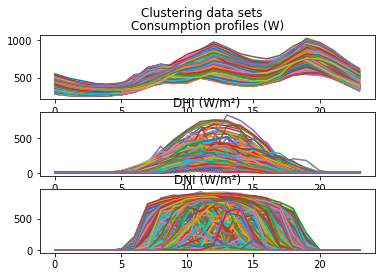

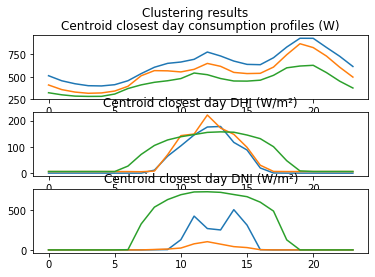

(array([ 50, 135, 180], dtype=int64), array([  3, 330, 240], dtype=int64))

In [15]:
# Clustering
from data.clustering import clustering
clustering('./data/irradiance_and_consumption_data.csv', 3, True)

Days 3, 240 and 330 correspond to the 4th of January, the 29th of August and the 27th of November. We recognise typical winter, summer, and mid-season days.

In [16]:
import matplotlib.pyplot as plt

summer_consumption = [yearly_consumption[h] for h in range(24*240,24*241)]
winter_consumption = [yearly_consumption[h] for h in range(24*3,24*4)]
mid_consumption = [yearly_consumption[h] for h in range(24*330,24*331)]

summer_irradiance = yearly_irradiance.iloc[24*240:24*241]
winter_irradiance = yearly_irradiance.iloc[24*3:24*4]
mid_irradiance = yearly_irradiance.iloc[24*330:24*331]

# Plotting these figures ?

# plt.figure(0)
# plt.plot(summer_consumption)
# plt.plot(winter_consumption)
# plt.plot(mid_consumption)
# plt.title('Typical days consumption profiles')
# plt.xlabel('Time(h)')
# plt.ylabel('Power (W)')

# plt.figure(1)
# plt.plot(summer_irradiance['DHI'].values)
# plt.plot(winter_irradiance['DHI'].values)
# plt.plot(mid_irradiance['DHI'].values)
# plt.title('Typical days DHI')
# plt.xlabel('Time(h)')
# plt.ylabel('DHI (W/m²)')

# plt.figure(2)
# plt.plot(summer_irradiance['DNI'].values)
# plt.plot(winter_irradiance['DNI'].values)
# plt.plot(mid_irradiance['DNI'].values)
# plt.title('Typical days DNI')
# plt.xlabel('Time(h)')
# plt.ylabel('DNI (W/m²)')


### Energy model

![NoLOAD_PV](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/dwelling_pv_self_consumption.png)

The energy model is a simplified one where the main variables and parameters consist in:
- pv_power (W): the power produced by the pv pannels depending on the irradiance values (W/m²) as well as the tilt (degree), azimuth (degree) and surface (m²) of the pannels. It is defined in the solarPV model.
- consumption (W): the consumption of the dwelling
- e_sto (Wh): the charged energy for export calculation, or discharged energy for import calculation
- import (Wh): the energy imported from the power grid, defined as the energy that is not self produced by the PV-batteries system.
- export (Wh): the energy exported to the power grid, defined as the energy that is not self-consumed by the PV-batteries system.

Energy import, export, pv_power and consumption are illustrated hereunder without the battery consideration:


In [8]:
import numpy as np
import models.solarPV as solarPV
# direct display in the notebook
%matplotlib inline 

# A PV power profile example...
tilt = 25
azimuth = 0
surface = 8

*NB: in this whole study, the tilt and azimuth are constant: no solar tracker is considered.*

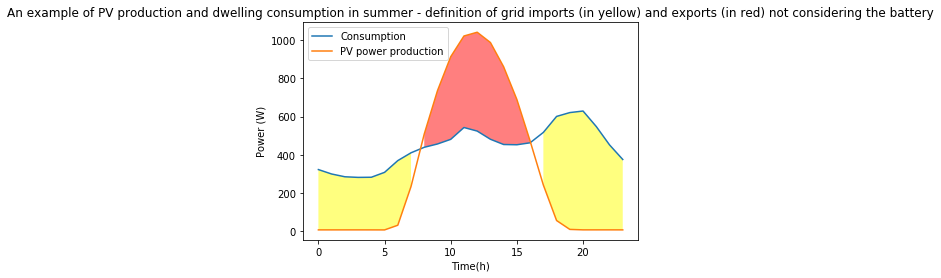

In [9]:
# # on the 29th of August 
solar_summer = solarPV.PVSolar(summer_irradiance.index.to_series())
DNI_summer = np.array(summer_irradiance['DNI'])
DHI_summer = np.array(summer_irradiance['DHI'])

pv_power_summer = solar_summer.pv_power(tilt, azimuth, surface, DNI_summer, 
                                        DHI_summer)

fig2, ax2 = plt.subplots()  
ax2.plot(summer_consumption, label='Consumption') 
ax2.plot(pv_power_summer, label='PV power production') 

plt.fill_between(np.arange(0,24), pv_power_summer, summer_consumption, 
                 where=summer_consumption >= pv_power_summer, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_summer, summer_consumption, 
                 where=pv_power_summer >= summer_consumption, facecolor='red', alpha=0.5)
ax2.set_xlabel('Time(h)')  
ax2.set_ylabel('Power (W)')  
ax2.set_title('An example of PV production and dwelling consumption '
              'in summer - '
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax2.legend()  

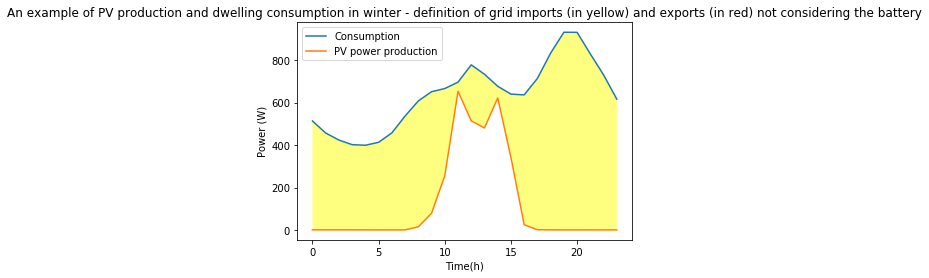

In [10]:
# ... in winter
solar_winter = solarPV.PVSolar(winter_irradiance.index.to_series())
DNI_winter = np.array(winter_irradiance['DNI'])
DHI_winter = np.array(winter_irradiance['DHI'])
pv_power_winter = solar_winter.pv_power(tilt, azimuth, surface, DNI_winter, 
                                        DHI_winter)

fig3, ax3 = plt.subplots()  
ax3.plot(winter_consumption, label='Consumption') 
ax3.plot(pv_power_winter, label='PV power production') 
plt.fill_between(np.arange(0,24), pv_power_winter, winter_consumption, 
                 where=winter_consumption >= pv_power_winter, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_winter, winter_consumption, 
                 where=pv_power_winter >= winter_consumption, facecolor='red', 
                 alpha=0.5)
ax3.set_xlabel('Time(h)')  
ax3.set_ylabel('Power (W)')  
ax3.set_title('An example of PV production and dwelling consumption '
              'in winter - '
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax3.legend()  

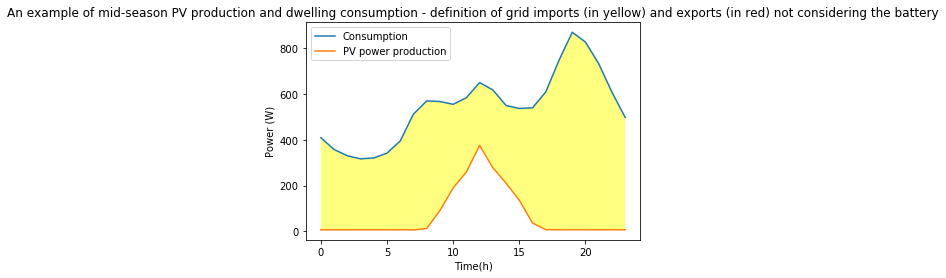

In [11]:
# ... in mid-season
solar_mid = solarPV.PVSolar(mid_irradiance.index.to_series())
DNI_mid = np.array(mid_irradiance['DNI'])
DHI_mid = np.array(mid_irradiance['DHI'])
pv_power_mid = solar_winter.pv_power(tilt, azimuth, surface, DNI_mid, 
                                        DHI_mid)

fig3, ax3 = plt.subplots()  
ax3.plot(mid_consumption, label='Consumption') 
ax3.plot(pv_power_mid, label='PV power production') 
plt.fill_between(np.arange(0,24), pv_power_mid, mid_consumption, 
                 where=mid_consumption >= pv_power_mid, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_mid, mid_consumption, 
                 where=pv_power_mid >= mid_consumption, facecolor='red', 
                 alpha=0.5)
ax3.set_xlabel('Time(h)')  
ax3.set_ylabel('Power (W)')  
ax3.set_title('An example of mid-season PV production and dwelling consumption - '             
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax3.legend()  

Then, what are going to be optimisation objectives can be defined: the Load Cover Factor (LCF) and Supply Cover Factor (SCF) can be relevant indicators:
- SCF: the percentage of the on-site generation that is used by the building. 

- LCF: the percentage of the electrical demand covered by on-site electricity generation. 

In our case, they can be calculated for each typical day as follow:
$$ SCF = \frac{E_{PV}-exports}{E_{PV}} $$
$$ LCF = \frac{E_{load}-imports}{E_{load}} $$

with E_PV and E_load respectively the energy in Watt-hours produced by the PV panels and consumed by the household during one day. Using both the LCF and SCF makes it possible to jointly minimise the household electricity exports and imports, sizing the PV system and the battery as close as possible to the needs, thus making the dwelling as imperceptible as possible from the grid point of view. 

In the case presented hereinbefore for instance:

In [12]:
e_sto = 1000  # value for the stored energy (Wh)
eff_sto_lead_acid = 0.75  # efficacity of the lead-acid battery

e_balance_vect = pv_power_summer - summer_consumption

# energy imported and exported, depending on hourly balance, and the total
# battery energy charged/discharged, taking into account the storage
# efficiency.
energy_import = -np.sum(e_balance_vect[e_balance_vect < 0]) \
                - eff_sto_lead_acid * e_sto
energy_export = np.sum(e_balance_vect[e_balance_vect > 0]) \
                - eff_sto_lead_acid * e_sto

pv_supply = pv_power_summer.sum()  # PV energy
load = sum(summer_consumption)  # Load energy
e_balance = np.sum(e_balance_vect)
coverage = pv_supply - energy_export
# checking the definition with another one :
coverage2 = load - energy_import
assert (abs(coverage - coverage2) < 1e-5)
# defining the cover factors, between 1 and 0 :
supply_cover_factor = coverage / pv_supply
load_cover_factor = coverage / load

print('The supply cover factor is {0} and the load cover factor is {1} for this summer day example.'.format(round(supply_cover_factor, 2), round(load_cover_factor,2)))

The supply cover factor is 0.72 and the load cover factor is 0.54 for this summer day example.


The storage energy values (e_sto) in the various typical days corresponds to the battery charge for export calculations, and discharged for export calculations. The battery actual capacity is the maximum between these values, and it takes into account state of charge actual limitations.   

For monoobjective optimisation (minimisation), a non-coverage indicator can be used, taking into account both the SCF and LCF. So doing, the PV and batteries are not oversized and the PV integration is as transparent as possible from a power grid point of view. The non-coverage indicator is defined as follows:  
$$ non-coverage = \sum_{0 \leqslant d < nb_days} \frac{w_d}{365} * \frac{(1-LCF_d)+(1-SCF_d)}{2} $$
Where : 
- nb_days is the number of typical days
- w_d is the weight of each typical day
- LCF_d is the load cover factor for a given typical day
- SCF_d is the supply cover factor for a given typical day  

*NB*: non-LCF and non-SCF indicators are defined the same way with typical day weights, and can be used as objectives.

### Life Cycle Analysis (LCA)
The LCA considerations on this study case are limited to the single environmental impact of Global Warming Potential (eq kgCO2), considered on the whole life cycle.  
**Functional unit**: consuming electricity according to a given consumption profile for 30 years with a 4586 kWh yearly consumption, from power grid and PV-battery system electricity.  
The values presented hereunder for the energy components are coming from minsterial data sets for [mono-crystalline PV](https://www.base-inies.fr/iniesV4/dist/consultation.html?id=8519) and [lead-acid batteries](https://www.base-inies.fr/iniesV4/dist/consultation.html?id=5638). The CO2 emissions from the French power grid come from the [ADEME online database](http://bilans-ges.ademe.fr/) and are related to the 2018 consumption mean value, and the ones from the european power grid can be found on the [EEA webiste](https://www.eea.europa.eu/data-and-maps/daviz/co2-emission-intensity-5#tab-googlechartid_chart_11_filters=%7B%22rowFilters%22%3A%7B%7D%3B%22columnFilters%22%3A%7B%22pre_config_ugeo%22%3A%5B%22European%20Union%20(current%20composition)%22%5D%7D%7D).

In [13]:
pv_gwp_raw = 4738.2  # for 6.67m² - 1kWp, monocristalline silicon 30 years lifespan
battery_gwp_raw = 351  # Lead-acid battery [capacity=200Ah], 38.6kg
battery_lifespan = 3  # Lead-acid battery lifespan
dod_lead_acid = 0.5  #depth of discharge lead-acid = 50%
# french electricity mix, consumption mean value, http://bilans-ges.ademe.fr/ 2018
french_power_grid_emissions_raw = 0.0571  # (kgCO2eq / kWh) 
# european electricity mix, data from EEA 2017
european_power_grid_emissions = 0.296

study_time = 30  # years

# Applying coefficients to abide by the functional unit
pv_gwp = pv_gwp_raw / 6.67 * 1  # 1kWp => 1 m² , 30 years
battery_gwp = battery_gwp_raw / (200 * 12) * study_time/battery_lifespan  # 200Ah, 12V, 3 years => 1000 Wh, 30 years

The Global Warming Potential (GWP) of the system will then be calculated as follow:  
$$ GWP\;(kg CO_2 eq)= GWP_{PV}\;(kg CO_2 eq/m²) * area_{PV}\;(m²) + GWP_{battery}\;(kg CO_2 eq/Wh) * capacity\:battery\;(Wh)+ French\:power\:grid\:emissions\:(kg CO_2 eq/kWh) * import\:grid\;(kWh\:over\:a\:year) * study\:time\ (years) $$  

The photovoltaic pannels and battery GWP factors take into account these equipments lifespan.  

Calculation example with the previously used values:

In [14]:
sum_nrj_balance_vect = pv_power_winter - summer_consumption
win_nrj_balance_vect = pv_power_winter - winter_consumption
mid_nrj_balance_vect = pv_power_mid - mid_consumption

# daily energy imports
sum_nrj_import = -np.sum(sum_nrj_balance_vect[sum_nrj_balance_vect < 0]) - e_sto
win_nrj_import = -np.sum(win_nrj_balance_vect[win_nrj_balance_vect < 0]) - e_sto
mid_nrj_import = -np.sum(mid_nrj_balance_vect[mid_nrj_balance_vect < 0]) - e_sto

capa_bat = e_sto / dod_lead_acid 
# weight of typical days: 
typical_day_nb = 3
typical_day_weight = [50, 180, 135]
typical_day_indice = [3, 240, 330]
import_list = [win_nrj_import, sum_nrj_import, mid_nrj_import]

# electricity imported from the grid over a year (kWh) 
grid_import = 0
for d in range(0, typical_day_nb):
    grid_import += typical_day_weight[d] * (import_list[d]) * 0.001  # kWh

GWP = pv_gwp * surface + battery_gwp * capa_bat + european_power_grid_emissions * grid_import * study_time
print('Global Warming Potential = {0} eq kg CO2 for an energy import of {1} kWh over 30 years'.format(round(GWP,2), round(grid_import,2)))

Global Warming Potential = 37038.7 eq kg CO2 for an energy import of 3201.66 kWh over 30 years


## 2. Optimisation problem

A bi-objective optimisation can be performed in order to maximise the local energy coverage while minimising the Global Warming Potential of the PV modules, battery and inverter over 30 years on the European power grid, and on their whole life cycle.  

### Optimisation problem definition

In order to define the optimisation problem, you first need the parameters required for the model computation, already defined hereinbefore: typical days irradiances and consumption profiles.  
Then you need to define optimisation variables as well as their bounds and initial values:
- The PV pannels
  - surface,
  - tilt
  - azimuth
- The energy of the storage for each typical day

In [15]:
cons_list = load_consumption_index(
            './data/irradiance_and_consumption_data.csv', typical_day_indice)
irr_list = load_irradiance_index(
            './data/irradiance_and_consumption_data.csv', typical_day_indice)

# creating parameters required for the model computation :
inputs = {'irradiance_list': irr_list,
          'consumption_list': cons_list,
          'typical_day_nb': typical_day_nb,
          'typical_day_weight': typical_day_weight}

# defining optimisation variables
x_names = ['surface', 'tilt', 'azimuth', 'e_sto_1', 'e_sto_2',
                   'e_sto_3']  # variables to optimize

# defining optimisation bounds
e_sto_max = 1000  # capacity below 5 kWh
pv_area_min = 1  # PV area above 1 m²
pv_area_max = 21  # PV area below 21 m²
bounds = [[pv_area_min, pv_area_max], [0, 90], [-80, 80], [0, e_sto_max],
          [0, e_sto_max], [0, e_sto_max]]

# initial values
e_sto_0_value = 500  # initial capacity value
pv_area_0 = 15
tilt_0 = 45
azimuth_0 = 0
x0 = [pv_area_0, tilt_0, azimuth_0, e_sto_0_value, e_sto_0_value,
      e_sto_0_value]

The optimisation problem can then be created with **NoLOAD**.  
The objective needs to be chosen, i.e. the value to minimise in the optimisation. It can be either the non-coverage (`non_coverage`), non-scf (`non_scf`), non-lcf (`non_lcf`), or the Global Warming Potential (`gwp`).

In [16]:
objectives = ['non_lcf']

In [17]:
from noload.optimization.optimProblem import Spec, OptimProblem
import models.model as model

# imports and exports mathematically positive or null
ineq_bounds = [[0, None], [0, None], [0, None], [0, None], [0, None],
               [0, None]]

spec = Spec(variables=x_names, bounds=bounds, xinit=x0,
             objectives=objectives,
             ineq_cstr=['import_0', 'import_1',
                        'import_2', 'export_0',
                        'export_1', 'export_2'],
             ineq_cstr_bnd=ineq_bounds)


# define the optimisation
optim = OptimProblem(model=model.objectives_and_constraints,
                     specifications=spec, parameters=inputs)

Once defined, you can run the optimisation with relevant parameters:

In [18]:
ftol=1e-16  # float, Precision goal for the value of f in the stopping criterion.
maxiter=1000  # int, maximum number of iteration

### Optimisation solution and results

In [19]:
result = optim.run(ftol=ftol, maxiter=maxiter)
[surface, tilt, azimuth, e_sto_1, e_sto_2, e_sto_3] = optim.wrapper.solution()   

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5313980082037048
            Iterations: 246
            Function evaluations: 851
            Gradient evaluations: 245


{'surface': 21.0, 'tilt': 26.34498127073155, 'azimuth': 27.907539938356383, 'e_sto_1': 1000.0, 'e_sto_2': 1000.0, 'e_sto_3': 484.5090180742152}
{'non_lcf': 0.5313980082037048, 'import_0': 10040.034178324193, 'import_1': 4104.055998509276, 'import_2': 8840.414974384154, 'export_0': 2803.0057572452147, 'export_1': 14330.438971718808, 'export_2': 5.684341886080802e-14}
gwp   	 = 39457.82913379524
capa_bat   	 = 2000.0
max_e_sto   	 = 1000.0
dod_li_ion   	 = 0.8
dod_lead_acid   	 = 0.5
d   	 = 2
non_lcf   	 = 0.5313980082037048
non_scf   	 = 0.3870272667720994
grid_export   	 = 2719.629302771646
grid_import   	 = 2434.18781018974
non_coverage   	 = 0.45921263748790214
import_2   	 = 8840.414974384154
import_1   	 = 4104.055998509276
import_0   	 = 10040.034178324193
export_2   	 = 5.684341886080802e-14
export_1   	 = 14330.438971718808
export_0   	 = 2803.0057572452147
i   	 = 2
e_sto_list   	 = [1000.0, 1000.0, 484.5090180742152]
e_balance_list   	 = [-7237.028421078978, 10226.38297320953

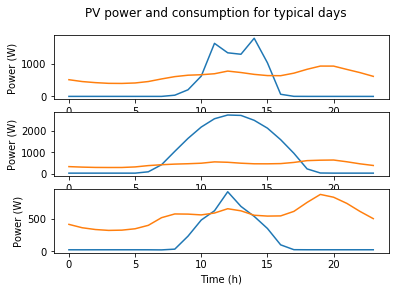

Results for each typical day with (surface, tilt, azimuth) = (21.0, 26.34, 27.91)


In [20]:
from optim.optim_definition import plot_results
# print results
result.printResults()
for name, value in result.rawResults.items():
    if not (('irradiance' in name) or ('consumption' in name)):
        print(name, '  \t =', value)

plot_results(surface=surface, tilt=tilt, azimuth=azimuth,
                             irradiance_list=irr_list, consumption_list=cons_list, 
                             typical_day_nb=typical_day_nb)
sta = [round(value,2) for value in [surface, tilt, azimuth]]
print('Results for each typical day with (surface, tilt, azimuth) = ({0}, {1}, {2})'.format(*sta))

### Pareto
Generally speaking, the GWP objective takes into account the environmental impact of the PV panels and batteries compared to grid electricity emissions in the system sizing: it is complementary to the sole LCF objective that tends to maximise PV and battery sizing for local energy coverage. As a result, LCF and GWP will be the two objective used in the following Pareto. The SCF and non-coverage indicators can still be used alternative studies.

In [24]:
from noload.optimization.optimProblem import Spec, OptimProblem
import models.model as model

pareto_objectives = ['non_lcf', 'gwp']

spec = Spec(variables=x_names, bounds=bounds, xinit=x0,
             objectives=pareto_objectives,
             ineq_cstr=['import_0', 'import_1',
                        'import_2', 'export_0',
                        'export_1', 'export_2'],
             ineq_cstr_bnd=ineq_bounds)

# New maximal capacity definition
e_sto_max = 1000
spec.bounds[3] = [0, e_sto_max]
spec.bounds[4] = [0, e_sto_max]
spec.bounds[5] = [0, e_sto_max]

# define the optimisation
optimPareto = OptimProblem(model=model.objectives_and_constraints,
                           specifications=spec, parameters=inputs)

# Number of points in the Pareto
nbParetoPts = 8

In [25]:
resultPareto = optimPareto.run(ftol=ftol, maxiter=maxiter, nbParetoPts=nbParetoPts)
resultPareto.printResults()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5313980082037048
            Iterations: 246
            Function evaluations: 851
            Gradient evaluations: 245
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 33691.199319265856
            Iterations: 155
            Function evaluations: 730
            Gradient evaluations: 154
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 36343.616389840856
            Iterations: 219
            Function evaluations: 820
            Gradient evaluations: 218
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5602471322322822
            Iterations: 220
            Function evaluations: 487
            Gradient evaluations: 220
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 34305.56977508757
            Iterations: 203
       

The convergence can be tough, depending on the tolerance (ftol<1e-8) and the number of iteration (maxiter>200). Pareto points can be badly gathered, so you are not forced to join them.

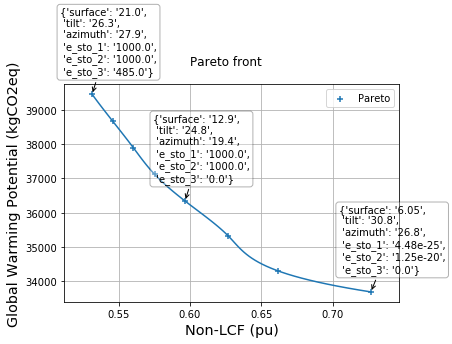

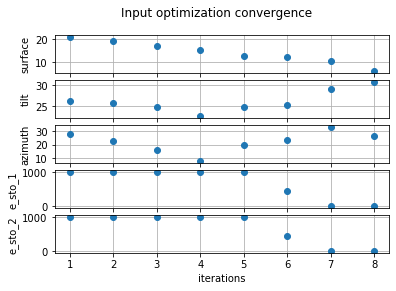

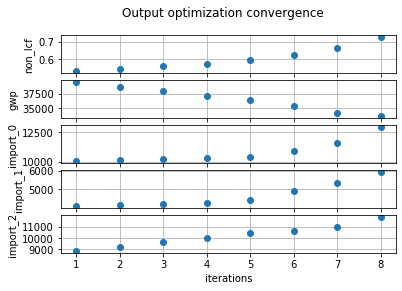

gwp   	 = 38679.275947806644
capa_bat   	 = 2000.0
max_e_sto   	 = 1000.0
dod_li_ion   	 = 0.8
dod_lead_acid   	 = 0.5
d   	 = 2
non_lcf   	 = 0.5457064408833707
non_scf   	 = 0.36570597894054574
grid_export   	 = 2359.1470601221495
grid_import   	 = 2500.315631307396
non_coverage   	 = 0.4557062099119582
import_2   	 = 9218.384126963447
import_1   	 = 4166.621130385138
import_0   	 = 10116.839413960122
export_2   	 = 1.1368683772161603e-13
export_1   	 = 12513.625461250642
export_0   	 = 2133.8895419406786
i   	 = 2
e_sto_list   	 = [999.9999999997007, 1000.0, 246.2832071309619]
e_balance_list   	 = [-7982.949872019446, 8347.004330865506, -9218.384126963449]
coverage_list   	 = [5151.901133039877, 6440.271310214863, 3833.9377295365516]
load_list   	 = [15268.740547000001, 10606.8924406, 13052.321856499999]
supply_list   	 = [7285.790674980555, 18953.896771465505, 3833.9377295365516]
export_list   	 = [2133.8895419406786, 12513.625461250642, 1.1368683772161603e-13]
import_list   	 = [1

In [26]:
import noload.gui.plotPareto as pp

pp.plot([resultPareto.resultsHandler], ['Non-LCF (pu)', 'Global Warming '
                                                      'Potential (kgCO2eq)'],
        ['Pareto'], nb_annotation=2, joinDots=True)

resultPareto.plotResults()

for name, value in resultPareto.rawResults.items():
    if not (('irradiance' in name) or ('consumption' in name)):
        print(name, '  \t =', value)

### Interpretation

A slight bend can be observed when the non-LCF indicator falls below a value of about 0.65. It is noticeable that it is from this point that the capacity of the batteries and the surface area of the PV panels increase both. In addition, the azimuth values here remain relatively constant with a South - South-East orientation, which would therefore be optimal for covering the consumption profiles with PV production.  
It can be seen that in order to maximise the coverage, both the surface of the photovoltaic panels and the battery capacity reach their upper limits to store the PV production of the summer day. The inclination of the panels is 26° and the azimuth equals 28°. Such sizing is intended to maximise the annual producton with no regards for grid exports issues. Smarter sizing could be explored with the non-coverage indicator for instance, maximising the production when its the most needed (in winter) with relevant azimuth and tilt.
For the GWP minimisation objective, the battery capacity is sized at zero, and the PV panels have a surface of 6 m² with an inclination of 31°. This sizing allows PV production to replace imports from the grid as much as possible without the use of batteries, thus falling below 34 tons of CO2 eq. of GWP. A quick calculation allows us to compare this value with that of a GWP without a PV system, which amounts to 40.7 tons of CO2 eq. for 30 years of consumption on the electricity grid alone, with a European mix. This GWP of the grid is also a good indication to situate relatively the GHG emissions of the different sizes presented in the Pareto curve.  

These results are only valid with the GWP assumptions and data presented above. Generally speaking, these results are of course dependent on the input data, assumptions made and modelling choices implemented. 

The results presented here enable to to choose a sizing for the energy system and to look into the battery management. Such study as well as the summary of the complete study including this one is described in the following [OMEGAlpes Jupyter Notebook](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/blob/master/notebooks/article_2021_BS_ORUCE.ipynb).

### Limits
The energy model is very simplified: a dynamic calculation of the storage capacity could be carried out to reflect more accurately the operation and management of the storage. This would also make it possible to integrate the dynamics of the network's CO2 emissions and to observe the details of power flows at each time step, thus improving the general understanding of the energy system. Such control could be achieved using MILP linear optimisation techniques.  
In addition, more refined modelling hypotheses could be adopted over the 30 years considered, such as the ageing of batteries and PV panels or the evolution of energy mixes. In addition, part of the consumption profiles could be controlled to reflect a possible adaptation of consumption to local production. A more in-depth study of the clustering results, particularly in terms of distortion of the clusters formed around the centroids, would also make it possible to have a number of centroids adapted for a better representativeness. Finally, it would be interesting to carry out the study at the neighbourhood scale in order to qualify and quantify the consequences on the electricity network, and to evaluate the relevance of the dimensioning with the indicators presented here.  

With regard to the method and data used for LCA, GWP was chosen here because it is an accessible indicator directly linked to climate change, but the consideration of other environmental impacts such as soil and water acidification or the depletion of non-renewable resources would be relevant for a more complete vision. One of the main difficulties concerning open LCA remains the access to data and tools, and the variability of data: on the single GWP indicator of monocrystalline PV panels alone, the differences between values from different reliable sources exceed a factor of 3. In addition to the fact that the calculation of GHG emissions from PV modules depends on a large number of factors, this variability can be explained on the one hand by whether or not connectors and inverters are taken into account in the impact calculation, and on the other hand by the origin of the PV panels as highlighted by *Yue et al, « Domestic and overseas manufacturing scenarios of silicon-based photovoltaics: Life cycle energy and environmental comparative analysis », Solar Energy, vol. 105, p. 669‑678, juill. 2014, doi: 10.1016/j.solener.2014.04.008.*. In this respect, the [BONSAI project's](https://bonsai.uno/) initiative to deploy an open database for LCA data is very relevant and promising.